Dataset used:- "Indian vehicle license plate dataset"

Source:- https://www.kaggle.com/datasets/saisirishan/indian-vehicle-dataset?resource=download

Download via:- Download_kaggle_dataset.ipynb

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [103]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./google_images\0073797c-a755-4972-b76b-8ef2b3...,140,339,210,260
1,./google_images\00b42b2c-f193-4863-b92c-0245cb...,184,292,572,648
2,./google_images\018b52e6-e9a1-42c2-8ce7-0617e8...,327,399,202,227
3,./google_images\03273806-bb1e-48da-8c8b-a0133a...,185,374,290,339
4,./google_images\0369b20e-b432-4409-90f9-242087...,335,453,313,347


In [104]:
import xml.etree.ElementTree as xet

In [105]:
filename = df['filepath'][0]
filename

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.xml'

In [106]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./google_images',filename_image)
    return filepath_image

In [107]:
getFilename(filename)

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg'

In [108]:
image_path = list(df['filepath'].apply(getFilename))
image_path 

['./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg',
 './google_images\\00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.jpg',
 './google_images\\018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_sbtb02_auto1.JPG',
 './google_images\\03273806-bb1e-48da-8c8b-a0133a90197a___2014-Skoda-Yeti-Test-Drive.jpg.jpeg',
 './google_images\\0369b20e-b432-4409-90f9-2420877aa386___8151536c79159a1557421da5f27f9f0e.jpg.jpeg',
 './google_images\\07064c2c-2aa3-4419-91a4-92916de8e54c___mahindra-scorpio-old-car-500x500.jpg.jpeg',
 './google_images\\074d85b8-42ec-4d17-9b8e-9e51ae060243___hqdefault.jpg.jpeg',
 './google_images\\07aaab79-71ee-4ea3-a9e6-640191183947___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_1208484d1392541449-nissan-terrano-official-review-img_20140215_181708.jpg',
 './google_images\\07bd977e-d578-49a2-b345-7cee5a4db6bf___new_1031520d1356604430-skoda-r

#### Verify image and output

In [109]:
file_path = image_path[0]
file_path 

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg'

In [110]:
img = cv2.imread(file_path)

#cv2.namedWindow('example',cv2.WINDOW_NORMAL)
#cv2.imshow('example',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


cv2.namedWindow('imageWindow')
cv2.imshow('imageWindow',img)
wait = True
while wait:
  wait = cv2.waitKey()=='q113' # hit q to exit

In [111]:
# 1093	1396	645	727
cv2.rectangle(img,(140,210),(334,252),(0,255,0),3)
cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Data Preprocessing

In [112]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [113]:
labels = df.iloc[:,1:].values

In [114]:
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # pre-processing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [115]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [116]:
X.shape,y.shape

((440, 224, 224, 3), (440, 4))

In [117]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((352, 224, 224, 3), (88, 224, 224, 3), (352, 4), (88, 4))

### Deep Learning Model

In [118]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [119]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [120]:
# compile model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_208 (Batch  (None, 25, 25, 96)  288         ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_210 (Batch  (None, 25, 25, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_213 (Batch  (None, 25, 25, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 25, 25, 64)  192         ['conv2d_214[0][0]']             
 Normaliza

 activation_224 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_224[0][0]']
                                                                                                  
 conv2d_222 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_225 (Conv2D)            (None, 25, 25, 48)   13824       ['activation_224[0][0]']         
                                                                                                  
 batch_normalization_222 (Batch  (None, 25, 25, 32)  96          ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_225 (Batch  (None, 25, 25, 48)  144         ['conv2d_225[0][0]']             
 Normaliza

                                                                                                  
 activation_227 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_227[0][0]']
                                                                                                  
 activation_229 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_229[0][0]']
                                                                                                  
 activation_232 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_232[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_227[0][0]',         
                                                                  'activation_229[0][0]',         
                                                                  'activation_232[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_243 (Batch  (None, 25, 25, 48)  144         ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_240 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_240[0][0]']
                                                                                                  
 activation_243 (Activation)    (None, 25, 25, 48)   0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_239 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_245[0][0]',         
                                                                  'activation_247[0][0]',         
                                                                  'activation_250[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_261 (Activation)    (None, 25, 25, 48)   0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_259 (Conv2D)            (None, 25, 25, 32)   9216        ['activation_258[0][0]']         
                                                                                                  
 conv2d_262 (Conv2D)            (None, 25, 25, 64)   27648       ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_257 (Batch  (None, 25, 25, 32)  96          ['conv2d_257[0][0]']             
 Normalization)                                                                                   
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_272 (Conv2D)            (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_272 (Batch  (None, 25, 25, 32)  96          ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_272 (Activation)    (None, 25, 25, 32)   0           ['batch_normalization_272[0][0]']
          

 activation_278 (Activation)    (None, 12, 12, 384)  0           ['batch_normalization_278[0][0]']
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_275[0][0]',         
                                )                                 'activation_278[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_280 (Conv2D)            (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_288 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_288 (Batch  (None, 12, 12, 128)  384        ['conv2d_288[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_296 (Conv2D)            (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_296 (Batch  (None, 12, 12, 128)  384        ['conv2d_296[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_296 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_296[0][0]']
                                                                                                  
 conv2d_297 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_296[0][0]']         
          

                                                                                                  
 batch_normalization_304 (Batch  (None, 12, 12, 128)  384        ['conv2d_304[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_305 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_305 (Batch  (None, 12, 12, 160)  480        ['conv2d_305[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_312 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_312[0][0]']
                                                                                                  
 conv2d_313 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_312[0][0]']         
                                                                                                  
 batch_normalization_313 (Batch  (None, 12, 12, 160)  480        ['conv2d_313[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_313 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_313[0][0]']
                                                                                                  
 conv2d_31

 conv2d_321 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_320[0][0]']         
                                                                                                  
 batch_normalization_321 (Batch  (None, 12, 12, 160)  480        ['conv2d_321[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_321 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_321[0][0]']
                                                                                                  
 conv2d_319 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_322 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_321[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_329 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_329[0][0]']
                                                                                                  
 conv2d_327 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_330 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_329[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 12, 12, 192)  576        ['conv2d_327[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_335 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_338 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_337[0][0]']         
                                                                                                  
 batch_normalization_335 (Batch  (None, 12, 12, 192)  576        ['conv2d_335[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_338 (Batch  (None, 12, 12, 192)  576        ['conv2d_338[0][0]']             
 Normalization)                                                                                   
          

 conv2d_346 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_345[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 12, 12, 192)  576        ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_346 (Batch  (None, 12, 12, 192)  576        ['conv2d_346[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_343 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_343[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_354 (Batch  (None, 12, 12, 192)  576        ['conv2d_354[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_351 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_351[0][0]']
                                                                                                  
 activation_354 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_354[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_351[0][0]',         
          

 activation_359 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_359[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_361[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 conv2d_360 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_359[0][0]']         
                                                                                                  
 conv2d_362 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_361[0][0]']         
                                                                                                  
 conv2d_36

                                                                                                  
 activation_372 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_372[0][0]']
                                                                                                  
 conv2d_370 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_373 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_372[0][0]']         
                                                                                                  
 batch_normalization_370 (Batch  (None, 5, 5, 192)   576         ['conv2d_370[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_378 (Batch  (None, 5, 5, 192)   576         ['conv2d_378[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_381 (Batch  (None, 5, 5, 256)   768         ['conv2d_381[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_378 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_378[0][0]']
                                                                                                  
 activation_381 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_381[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_389 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_389[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_386[0][0]',         
                                                                  'activation_389[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_399 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_399 (Batch  (None, 5, 5, 192)   576         ['conv2d_399[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 flatten_1 (Flatten)            (None, 38400)        0           ['conv_7b_ac[0][0]']             
                                                                                                  
 dense_3 (Dense)                (None, 500)          19200500    ['flatten_1[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 250)          125250      ['dense_3[0][0]']                
                                                                                                  
 dense_5 (

### Model Training

In [121]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

In [122]:
tfb = TensorBoard('object_detection')
early_stopping = EarlyStopping()

In [123]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=150,
                    validation_data=(x_test,y_test), callbacks=[tfb])

Epoch 1/150
36/36 [==============================] - 401s 10s/step - loss: 0.0983 - val_loss: 0.0795
Epoch 2/150
36/36 [==============================] - 318s 9s/step - loss: 0.0757 - val_loss: 0.0777
Epoch 3/150
36/36 [==============================] - 305s 9s/step - loss: 0.0744 - val_loss: 0.0808
Epoch 4/150
36/36 [==============================] - 295s 8s/step - loss: 0.0767 - val_loss: 0.0816
Epoch 5/150
36/36 [==============================] - 304s 9s/step - loss: 0.0711 - val_loss: 0.0734
Epoch 6/150
36/36 [==============================] - 361s 10s/step - loss: 0.0671 - val_loss: 0.0723
Epoch 7/150
36/36 [==============================] - 338s 9s/step - loss: 0.0665 - val_loss: 0.0754
Epoch 8/150
36/36 [==============================] - 280s 8s/step - loss: 0.0667 - val_loss: 0.0722
Epoch 9/150
36/36 [==============================] - 312s 9s/step - loss: 0.0669 - val_loss: 0.0734
Epoch 10/150
36/36 [==============================] - 346s 10s/step - loss: 0.0684 - val_loss: 0.0

Epoch 81/150
36/36 [==============================] - 277s 8s/step - loss: 2.1102e-04 - val_loss: 0.0059
Epoch 82/150
36/36 [==============================] - 240s 7s/step - loss: 1.9466e-04 - val_loss: 0.0057
Epoch 83/150
36/36 [==============================] - 277s 8s/step - loss: 2.0878e-04 - val_loss: 0.0059
Epoch 84/150
36/36 [==============================] - 273s 8s/step - loss: 2.1974e-04 - val_loss: 0.0058
Epoch 85/150
36/36 [==============================] - 285s 8s/step - loss: 2.7542e-04 - val_loss: 0.0060
Epoch 86/150
36/36 [==============================] - 274s 8s/step - loss: 2.7641e-04 - val_loss: 0.0057
Epoch 87/150
36/36 [==============================] - 270s 8s/step - loss: 2.8047e-04 - val_loss: 0.0058
Epoch 88/150
36/36 [==============================] - 273s 8s/step - loss: 2.1430e-04 - val_loss: 0.0057
Epoch 89/150
36/36 [==============================] - 276s 8s/step - loss: 1.5952e-04 - val_loss: 0.0060
Epoch 90/150
36/36 [==============================] - 2

In [101]:
'''history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch=101)'''

In [124]:
model.save('./models/object_detection_150_epochs_indian-vehicle-dataset.h5')

In [ ]:
#It is preferable to create a small function for plotting metrics.:-

In [125]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

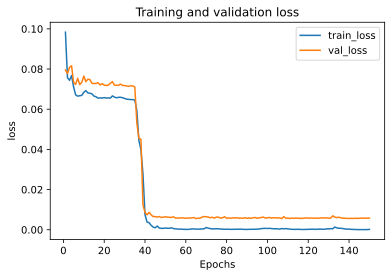

In [126]:
plot_metric(history, 'loss')

In [130]:
import keras

In [131]:
filename = r'./models/object_detection_150_epochs_indian-vehicle-dataset.h5'

In [132]:
model = keras.models.load_model(filename)

In [133]:
#evaluate(): is for evaluating the already trained model using the validation (or test) data and the corresponding labels. 
#Returns the loss value and metrics values for the model.
model.evaluate(x_test,y_test)


3/3 [==============================] - 95s 13s/step - loss: 0.0058


0.005773667711764574